In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import time
from keras.models import load_model
np.random.seed(21)

Using TensorFlow backend.


In [2]:
# load data with datetime index
crude_data = pd.read_csv('../data/NTPC/Daily/data.csv', parse_dates=[0])

# sort by date
crude_data.sort_values('Date', inplace=True)

# reindex dataframe
crude_data.set_index(keys=['Date'], drop=True, inplace=True)
print('='*40)

# check for missing values
print(crude_data.isnull().sum())
print('='*40)

# convert 'Change %' column entries to numbers
crude_data['Change %'] = crude_data['Change %'].apply(lambda x:float(x.split('%')[0]))

def convert(row):
    '''Function for converting volume entries to numbers
    Input: row ---> Row entry; for ex: 5.1M, 8.22K
    Output num ---> Volume in numbers; for ex: 5.1M to 5100000  
    '''
    if row[-1] == 'M':
        num = float(row[:-1])*1000000
    elif row[-1] == 'K':
        num = float(row[:-1])*1000
    elif row[-1] == '-':
        num = 0
    return num

# convert 'Vol.' column entries to numbers
crude_data['Vol.'] = crude_data['Vol.'].apply(lambda x:convert(x))

crude_data.head()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-05,180.35,180.54,181.09,179.62,106350.0,0.77
2010-11-08,177.41,181.09,181.09,177.18,668780.0,-1.63
2010-11-09,178.15,178.70,178.70,176.95,354580.0,0.42
2010-11-10,178.47,178.70,179.11,177.73,473680.0,0.18
2010-11-11,176.72,178.79,179.11,176.31,299980.0,-0.98


In [3]:
crude_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2035 entries, 2010-11-05 to 2019-01-21
Data columns (total 6 columns):
Price       2035 non-null float64
Open        2035 non-null float64
High        2035 non-null float64
Low         2035 non-null float64
Vol.        2035 non-null float64
Change %    2035 non-null float64
dtypes: float64(6)
memory usage: 111.3 KB


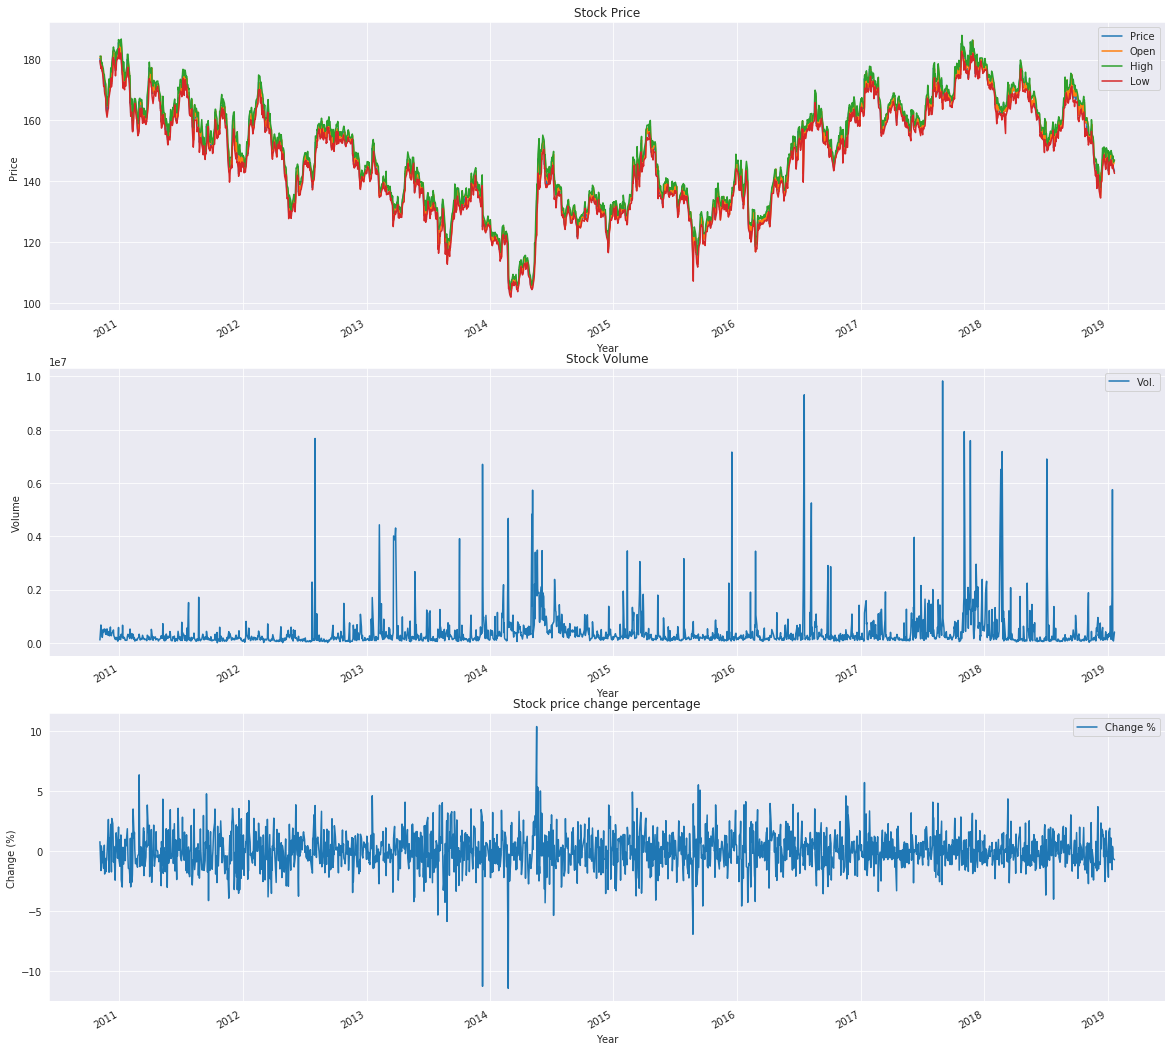

In [4]:
# initialize figure and axes
fig, (ax_1, ax_2, ax_3) = plt.subplots(3,1, figsize=(20,20))

# plot open, close, high and low prices
crude_data.plot(y=['Price', 'Open', 'High', 'Low'], ax=ax_1)
ax_1.set_title('Stock Price')
ax_1.set_xlabel('Year')
ax_1.set_ylabel('Price')

# plot volume
crude_data.plot(y='Vol.', ax=ax_2)
ax_2.set_title('Stock Volume')
ax_2.set_xlabel('Year')
ax_2.set_ylabel('Volume')

# plot percentage change
crude_data.plot(y='Change %', ax=ax_3)
ax_3.set_title('Stock price change percentage')
ax_3.set_xlabel('Year')
ax_3.set_ylabel('Change (%)')

plt.savefig('ntpc_daily_trends.png')

In [5]:
crude_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-05,180.35,180.54,181.09,179.62,106350.0,0.77
2010-11-08,177.41,181.09,181.09,177.18,668780.0,-1.63
2010-11-09,178.15,178.70,178.70,176.95,354580.0,0.42
2010-11-10,178.47,178.70,179.11,177.73,473680.0,0.18
2010-11-11,176.72,178.79,179.11,176.31,299980.0,-0.98


In [6]:
crude_data.shape

(2035, 6)

In [7]:
# split data
train_data = crude_data.iloc[:1800,:]
test_data = crude_data.iloc[1800:,:]

# normalize by splitting into window
window_size = 25
scaler = StandardScaler()

# normalize train data
for di in range(0, len(train_data), window_size):
    scaler.fit(train_data.iloc[di:di+window_size,:])
    train_data.iloc[di:di+window_size,:] = scaler.transform(train_data.iloc[di:di+window_size,:])

# normalize test data
test_data.iloc[:,:] = scaler.transform(test_data.iloc[:,:])

# split into train and test features and targets
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

In [8]:
X_train.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-05,1.541150,1.503606,1.765475,-2.240081,0.584254
2010-11-08,1.652464,1.503606,1.306734,2.196828,-1.142606
2010-11-09,1.168755,0.983636,1.263492,-0.281839,0.332421
2010-11-10,1.168755,1.072836,1.410139,0.657719,0.159735
2010-11-11,1.186970,1.072836,1.143167,-0.712569,-0.674914


In [9]:
X_test.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2018-02-07,-2.008514,-2.336264,-2.949931,0.407847,-0.058854
2018-02-08,-2.111331,-2.431700,-1.945740,-0.799363,-0.603796
2018-02-09,-2.574004,-1.899987,-2.531518,-0.482167,-0.017983
2018-02-12,-2.522595,-2.540769,-2.160924,-0.730529,1.644090
2018-02-14,-2.111331,-2.445333,-2.113105,-0.359228,-1.257726


In [10]:
y_train.head()

Date
2010-11-05    1.680586
2010-11-08    1.102646
2010-11-09    1.248114
2010-11-10    1.311019
2010-11-11    0.967007
Name: Price, dtype: float64

In [11]:
y_test.head()

Date
2018-02-07   -2.169162
2018-02-08   -2.492037
2018-02-09   -2.618380
2018-02-12   -2.183200
2018-02-14   -2.730684
Name: Price, dtype: float64

In [12]:
# initialize model with Keras
model = Sequential()

# add 3 LSTM layers with dropout
model.add(LSTM(input_dim=5, output_dim=10, return_sequences=True))
# model.add(Dropout(0.3))

model.add(LSTM(5, return_sequences=True))
# model.add(Dropout(0.1))

model.add(LSTM(10, return_sequences=False))
# model.add(Dropout(0.3))

# add Dense layer with ReLU activation
model.add(Dense(5,kernel_initializer="uniform",activation='relu'))        

# add Dense layer with Linear activation
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# start time
start = time.time()

# compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# model compilation time
print ('compilation time : ', time.time() - start)

compilation time :  0.04768848419189453


In [13]:
# Fit model on training data with validation data 5% of training data and 150 epochs
model.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),y_train, nb_epoch=100, validation_split=0.05, batch_size=25)

Train on 1710 samples, validate on 90 samples
Epoch 1/100
1710/1710 [==============================] - 5s 3ms/step - loss: 0.9984 - mean_squared_error: 0.9984 - val_loss: 1.0230 - val_mean_squared_error: 1.0230
Epoch 2/100
1710/1710 [==============================] - 2s 980us/step - loss: 0.9634 - mean_squared_error: 0.9634 - val_loss: 0.9181 - val_mean_squared_error: 0.9181
Epoch 3/100
1710/1710 [==============================] - 2s 1ms/step - loss: 0.6766 - mean_squared_error: 0.6766 - val_loss: 0.5966 - val_mean_squared_error: 0.5966
Epoch 4/100
1710/1710 [==============================] - 2s 974us/step - loss: 0.4459 - mean_squared_error: 0.4459 - val_loss: 0.4564 - val_mean_squared_error: 0.4564
Epoch 5/100
1710/1710 [==============================] - 2s 931us/step - loss: 0.3278 - mean_squared_error: 0.3278 - val_loss: 0.3283 - val_mean_squared_error: 0.3283
Epoch 6/100
1710/1710 [==============================] - 2s 938us/step - loss: 0.2277 - mean_squared_error: 0.2277 - val_lo

Epoch 50/100
1710/1710 [==============================] - 2s 928us/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 51/100
1710/1710 [==============================] - 2s 943us/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 52/100
1710/1710 [==============================] - 2s 960us/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 53/100
1710/1710 [==============================] - 2s 970us/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0485 - val_mean_squared_error: 0.0485
Epoch 54/100
1710/1710 [==============================] - 2s 982us/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 55/100
1710/1710 [==============================] - 2s 905us/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0489 - val_mean_squared_error:

1710/1710 [==============================] - 2s 938us/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 100/100
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0458 - val_mean_squared_error: 0.0458


In [14]:
# make predictions
y_pred = model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

# create copy of original test data to rescale data into original format
test_predictions = test_data.copy()

# set 'Price' feature value as predicted values
test_predictions[['Price']] = y_pred

# inverse transform predictions data
test_predictions.iloc[:,:] = scaler.inverse_transform(test_predictions)
preds = test_predictions.iloc[:,0]

# inverse transform original test data
test_data.iloc[:,:] = scaler.inverse_transform(test_data)
actual = test_data.iloc[:,0]

In [15]:
preds

Date
2018-02-07    163.963687
2018-02-08    165.081183
2018-02-09    165.775641
2018-02-12    165.852058
2018-02-14    164.702730
2018-02-15    164.591882
2018-02-16    165.176289
2018-02-19    166.788496
2018-02-20    166.288956
2018-02-21    163.881715
2018-02-22    163.779331
2018-02-23    166.969366
2018-02-26    164.553628
2018-02-27    165.859307
2018-02-28    164.919913
2018-03-01    164.299951
2018-03-05    164.116623
2018-03-06    164.758155
2018-03-07    164.924073
2018-03-08    166.703662
2018-03-09    165.149362
2018-03-12    170.746653
2018-03-13    168.347243
2018-03-14    170.845804
2018-03-15    169.338096
2018-03-16    165.761697
2018-03-19    167.972719
2018-03-20    165.987933
2018-03-21    170.831284
2018-03-22    170.104644
                 ...    
2018-12-10    162.323999
2018-12-11    161.837007
2018-12-12    163.532884
2018-12-13    161.775764
2018-12-14    163.241612
2018-12-17    164.406310
2018-12-18    162.279358
2018-12-19    162.536327
2018-12-20    162.45

In [16]:
actual

Date
2018-02-07    164.80
2018-02-08    163.65
2018-02-09    163.20
2018-02-12    164.75
2018-02-14    162.80
2018-02-15    162.90
2018-02-16    162.50
2018-02-19    163.00
2018-02-20    163.75
2018-02-21    162.25
2018-02-22    160.50
2018-02-23    162.80
2018-02-26    163.00
2018-02-27    165.50
2018-02-28    163.25
2018-03-01    163.00
2018-03-05    163.25
2018-03-06    163.05
2018-03-07    163.15
2018-03-08    165.30
2018-03-09    163.90
2018-03-12    171.00
2018-03-13    169.40
2018-03-14    170.00
2018-03-15    169.85
2018-03-16    165.35
2018-03-19    167.05
2018-03-20    166.10
2018-03-21    170.20
2018-03-22    170.50
               ...  
2018-12-10    136.30
2018-12-11    137.60
2018-12-12    140.80
2018-12-13    141.05
2018-12-14    143.65
2018-12-17    146.05
2018-12-18    147.80
2018-12-19    149.80
2018-12-20    149.10
2018-12-21    150.70
2018-12-24    146.85
2018-12-26    145.55
2018-12-27    148.00
2018-12-28    149.35
2018-12-31    148.65
2019-01-01    148.30
2019-01-

In [17]:
# calculate mean squared error on test data
error = np.sqrt(mean_squared_error(preds, actual))
print(error)

8.85539967931508


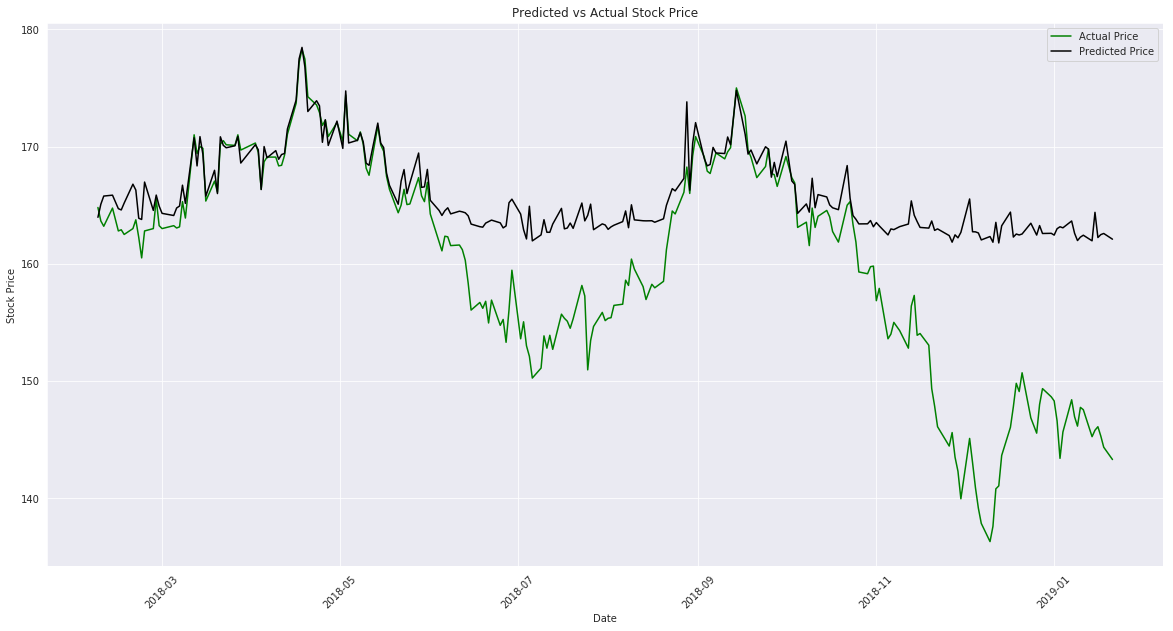

In [18]:
# compare original vs predicted stock prices
plt.figure(figsize=(20,10))
plt.plot(actual, color='green')
plt.plot(preds, color='black')
plt.legend(['Actual Price', 'Predicted Price'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Price')
plt.savefig('ntpc_daily.png')

In [19]:
comp = pd.DataFrame({'Actual':actual, 'Predicted':preds}, index=actual.index)
comp.head()

,Actual,Predicted
Date,,
2018-02-07,164.80,163.963687
2018-02-08,163.65,165.081183
2018-02-09,163.20,165.775641
2018-02-12,164.75,165.852058
2018-02-14,162.80,164.702730


In [21]:
comp.to_csv('ntpc_daily.csv')